In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from dynamic_tasker.orbits import *
from dynamic_tasker.access import *
from dynamic_tasker.schedulers import *
from dynamic_tasker.cameras import *


In [2]:
h = 400

requests = load_worldcities(5000)
t0 = datetime.datetime(2024, 1, 1, 12, 0, 0)
orbit = circular_orbit(a=Constants.R_E+h, i=np.deg2rad(51.6), Omega=np.pi - 0.05, M=np.pi/2, t=t0)
t_end = datetime.datetime(2024, 1, 1, 12, 10, 0)

accesses = get_accesses(requests, orbit, 500, 30, t0, t_end)
# Filter by AOI
accesses = [a for a in accesses if a.lat > 48 and a.lat < 54 and a.long > -5 and a.long < 10]

np.random.seed(5)
# set random access states
for a in accesses:
    a.state = {
        "observed": False,
        "cloudy": np.random.rand() < 0.64
    }

width=800
height=600

t_s = 10
t_dotsq = 2

def agility_bangbang(theta):
    return t_s + t_dotsq * np.sqrt(np.abs(theta))

schedule = milp_schedule(accesses, requests, agility_bangbang)

K = get_intrinsics(1000, width//2, height//2)
box_hires = create_box(width, height, 100)


In [3]:
def cartopy_fig():
    # Current orbit track
    fig = plt.figure(figsize=(4, 4), dpi=150)
    # Create a cartopy GeoAxes with PlateCarree projection
    ax = plt.axes(projection=ccrs.PlateCarree())

    # ax.stock_img(alpha=0.3)
    ax.coastlines()
    ax.add_feature(cfeature.LAND)
    ax.set_extent([-7.5, 2.5, 48, 54])

    # Add gridlines for latitude and longitude
    gridlines = ax.gridlines(draw_labels=True, linestyle='--', color='gray', alpha=0.5)
    gridlines.top_labels = False    # Disable labels at the top
    gridlines.right_labels = False  # Disable labels on the right
    gridlines.xlabel_style  = {'size': 7}
    gridlines.ylabel_style  = {'size': 7}

    return fig, ax

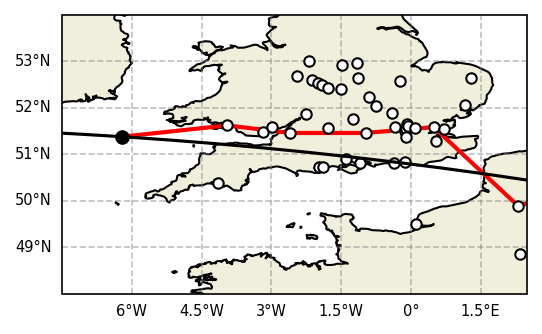

In [4]:
# FIGURE 1 -- Orbit initial position

fig, ax = cartopy_fig()
orbit_new = propagate_orbit(orbit, orbit.t + datetime.timedelta(seconds=70))
orbit_latlong = kepler2latlong(orbit_new, orbit_new.t)
orbit_track_latlong = np.array([kepler2latlong(orbit, orbit.t + datetime.timedelta(seconds=i)) for i in range(-100, 300, 10)])

# Plot the current schedule
ax.plot([orbit_latlong[1]] + [s.long for s in schedule], [orbit_latlong[0]] + [s.lat for s in schedule], 'r-', linewidth=2)
# Plot all the accesses
ax.plot([access.long for access in accesses], [access.lat for access in accesses], 'ko', fillstyle='full', markerfacecolor='white', markersize=5)
# Orbit track
ax.plot(orbit_track_latlong[:, 1], orbit_track_latlong[:, 0], 'k-')
ax.plot(orbit_latlong[1], orbit_latlong[0], 'ko')
plt.show()

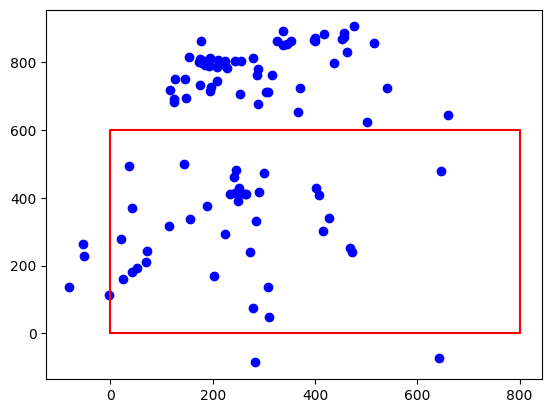

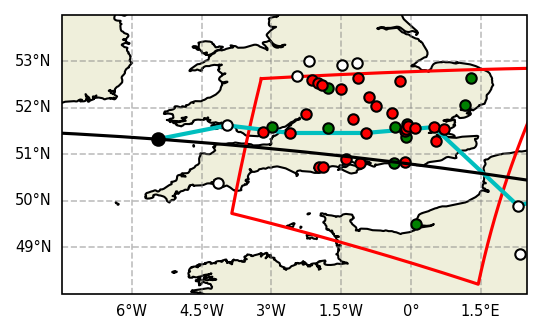

In [5]:
# FIGURE 2 -- Perform a lookahead

lookahead_action = 35
t = orbit.t + datetime.timedelta(seconds=agility_bangbang(lookahead_action - 20) - agility_bangbang(0)) + datetime.timedelta(seconds=70)
orbit_new = propagate_orbit(orbit, t)
orbit_latlong = kepler2latlong(orbit_new, orbit_new.t)

r, v = kepler2eci(orbit_new)
r_ecef = eci2ecef(r, orbit_new.t)
v_ecef = eci2ecef(v, orbit_new.t)

# Unproject the camera and intersect with Earth
ecef_unprojected_dir = -(r - unproject_from_orbit(box_hires, 1, K, orbit_new, t, pitch_angle=lookahead_action, roll_angle=0))# Calculate Earth line intersections in ECI
eci_intersections = [earth_line_intersection(r, d, horizon_snap=True)[0] for d in ecef_unprojected_dir]
latlong_intersections = [ecef2latlong(eci2ecef(i, t)) for i in eci_intersections]

points_eci = np.array([latlong2eci(a.lat, a.long, orbit_new.t) for a in accesses])

projected_points = project_from_orbit(points_eci, K, orbit_new, orbit_new.t, roll_angle=0, pitch_angle=lookahead_action)


for i, p in enumerate(projected_points):
    if(p[0] > 0 and p[0] < width and p[1] > 0 and p[1] < height):
        accesses[i].state["observed"] = True

# OK! Are the points in the box?
plt.plot(projected_points[:, 0], projected_points[:, 1], 'bo')
# Plot the box
plt.plot(box_hires[:, 0], box_hires[:, 1], 'r-')
plt.show()

fig, ax = cartopy_fig()

orbit_latlong = kepler2latlong(orbit_new, orbit_new.t)
orbit_track_latlong = np.array([kepler2latlong(orbit, orbit.t + datetime.timedelta(seconds=i)) for i in range(-100, 300, 10)])


# Plot the camera
plt.plot([a[1] for a in latlong_intersections], [a[0] for a in latlong_intersections], 'r', transform=ccrs.PlateCarree(), label='Lookahead')

# Plot the current schedule
ax.plot([orbit_latlong[1]] + [s.long for s in schedule], [orbit_latlong[0]] + [s.lat for s in schedule], 'c-', linewidth=2)
# Plot all the accesses
ax.plot([access.long for access in accesses if not access.state["observed"]], [access.lat for access in accesses if not access.state["observed"]], 'ko', fillstyle='full', markerfacecolor='white', markersize=5)
ax.plot([access.long for access in accesses if access.state["observed"] and not access.state["cloudy"]], [access.lat for access in accesses if access.state["observed"] and not access.state["cloudy"]], 'ko', fillstyle='full', markerfacecolor='green', markersize=5)
ax.plot([access.long for access in accesses if access.state["observed"] and access.state["cloudy"]], [access.lat for access in accesses if access.state["observed"] and access.state["cloudy"]], 'ko', fillstyle='full', markerfacecolor='red', markersize=5)
# Orbit track
ax.plot(orbit_track_latlong[:, 1], orbit_track_latlong[:, 0], 'k-')
ax.plot(orbit_latlong[1], orbit_latlong[0], 'ko')
plt.show()

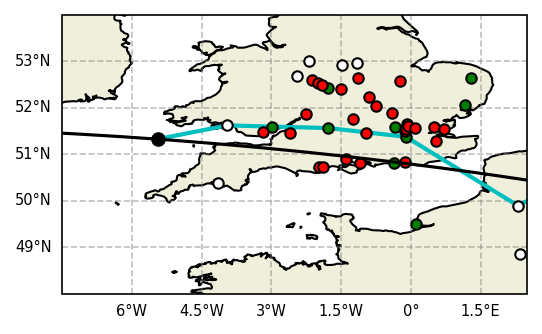

In [6]:
# FIGURE 3 -- Re-optimize lookahead track based on the new schedule

new_schedule = milp_schedule([a for a in accesses if not (a.state["observed"] and a.state["cloudy"])], requests, agility_bangbang)

fig, ax = cartopy_fig()

orbit_latlong = kepler2latlong(orbit_new, orbit_new.t)
orbit_track_latlong = np.array([kepler2latlong(orbit, orbit.t + datetime.timedelta(seconds=i)) for i in range(-100, 300, 10)])

# Plot the current schedule
ax.plot([orbit_latlong[1]] + [s.long for s in new_schedule], [orbit_latlong[0]] + [s.lat for s in new_schedule], 'c-', linewidth=2)
# Plot all the accesses
ax.plot([access.long for access in accesses if not access.state["observed"]], [access.lat for access in accesses if not access.state["observed"]], 'ko', fillstyle='full', markerfacecolor='white', markersize=5)
ax.plot([access.long for access in accesses if access.state["observed"] and not access.state["cloudy"]], [access.lat for access in accesses if access.state["observed"] and not access.state["cloudy"]], 'ko', fillstyle='full', markerfacecolor='green', markersize=5)
ax.plot([access.long for access in accesses if access.state["observed"] and access.state["cloudy"]], [access.lat for access in accesses if access.state["observed"] and access.state["cloudy"]], 'ko', fillstyle='full', markerfacecolor='red', markersize=5)
# Orbit track
ax.plot(orbit_track_latlong[:, 1], orbit_track_latlong[:, 0], 'k-')
ax.plot(orbit_latlong[1], orbit_latlong[0], 'ko')
plt.show()


0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276


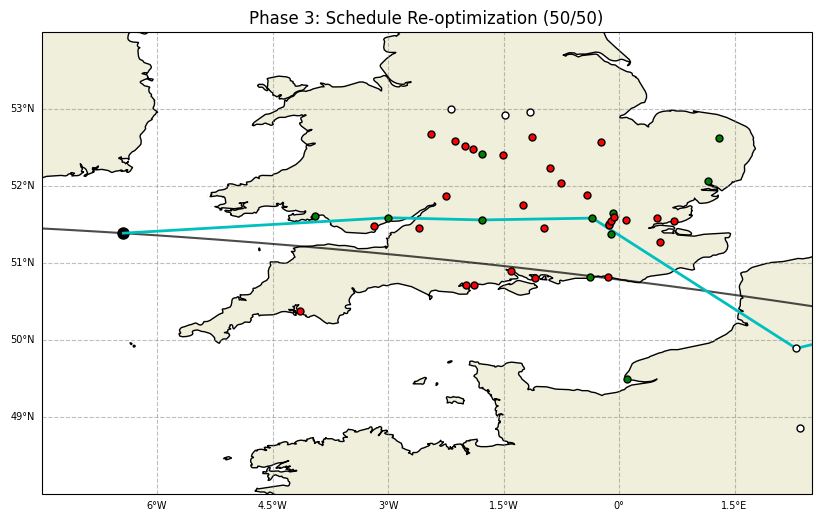

In [11]:
# IMPROVED ANIMATION -- Following orbit track, proper camera unproject, no fades

import matplotlib.animation as animation
from matplotlib.patches import Polygon
import copy

def create_improved_animation():
    # Reset accesses to initial state
    for a in accesses:
        a.state["observed"] = False
    
    # Animation parameters
    total_frames = 300
    phase1_frames = 100  # Spacecraft approach
    phase2_frames = 150  # Lookahead sweep
    phase3_frames = 50   # Schedule optimization
    
    # Pre-calculate orbit track for full animation (no fades)
    full_orbit_track_latlong = np.array([kepler2latlong(orbit, orbit.t + datetime.timedelta(seconds=i)) 
                                        for i in range(-200, 400, 5)])  # Extended range
    
    # Create figure
    fig, ax = plt.subplots(figsize=(8, 6), dpi=100, subplot_kw={'projection': ccrs.PlateCarree()})
    
    def animate(frame):
        print(frame)
        ax.clear()
        
        # Setup base map
        ax.coastlines()
        ax.add_feature(cfeature.LAND)
        ax.set_extent([-7.5, 2.5, 48, 54])
        gridlines = ax.gridlines(draw_labels=True, linestyle='--', color='gray', alpha=0.5)
        gridlines.top_labels = False
        gridlines.right_labels = False
        gridlines.xlabel_style = {'size': 7}
        gridlines.ylabel_style = {'size': 7}
        
        # Always show full orbit track (no fades)
        ax.plot(full_orbit_track_latlong[:, 1], full_orbit_track_latlong[:, 0], 'k-', alpha=0.7)
        
        if frame < phase1_frames:
            # PHASE 1: Spacecraft follows orbit track from left
            progress = frame / phase1_frames
            
            # Find spacecraft position along orbit track
            # Start from earlier time and progress to initial position
            start_time_offset = -60  # Start 150 seconds before reference time
            end_time_offset = 60      # End at reference time + 70 seconds
            current_time_offset = start_time_offset + (end_time_offset - start_time_offset) * progress
            
            current_orbit_time = orbit.t + datetime.timedelta(seconds=current_time_offset)
            current_orbit_state = propagate_orbit(orbit, current_orbit_time)
            current_latlong = kepler2latlong(current_orbit_state, current_orbit_time)
            
            # Plot spacecraft at current position along orbit
            ax.plot(current_latlong[1], current_latlong[0], 'ko', markersize=8)
            
            # Show original schedule (no fade)
            initial_latlong = kepler2latlong(orbit, orbit.t + datetime.timedelta(seconds=60))
            ax.plot([initial_latlong[1]] + [s.long for s in schedule], 
                   [initial_latlong[0]] + [s.lat for s in schedule], 
                   'r-', linewidth=2)
            
            # Show all accesses as unobserved
            ax.plot([access.long for access in accesses], [access.lat for access in accesses], 
                   'ko', fillstyle='full', markerfacecolor='white', markersize=5)
            
            ax.set_title(f'Phase 1: Spacecraft Approach ({frame+1}/{phase1_frames})')
            
        elif frame < phase1_frames + phase2_frames:
            # PHASE 2: Lookahead sweep using camera unproject flow
            phase2_progress = (frame - phase1_frames) / phase2_frames
            
            # Calculate current pitch angle (sweep from 35 to lookahead_action)
            current_pitch = 20 + (lookahead_action - 20) * phase2_progress
            
            # Calculate spacecraft position during maneuver
            maneuver_time = orbit.t + datetime.timedelta(seconds=agility_bangbang(current_pitch - 20) - agility_bangbang(0))
            current_orbit = propagate_orbit(orbit, maneuver_time)
            
            # Calculate observation time (70 seconds after maneuver)
            observation_time = maneuver_time + datetime.timedelta(seconds=60)
            
            # Propagate orbit to observation time for consistent calculations
            observation_orbit = propagate_orbit(orbit, observation_time)
            current_latlong = kepler2latlong(observation_orbit, observation_time)
            
            # Plot spacecraft position
            ax.plot(current_latlong[1], current_latlong[0], 'ko', markersize=8)
            
            # Calculate and show camera footprint using unproject flow
            # Use observation_orbit and observation_time for consistency
            r, v = kepler2eci(observation_orbit)
            
            # Use the camera unproject flow to get actual coverage area
            ecef_unprojected_dir = -(r - unproject_from_orbit(box_hires, 1, K, observation_orbit, 
                                                             observation_time, pitch_angle=current_pitch, roll_angle=0))
            eci_intersections = [earth_line_intersection(r, d, horizon_snap=True)[0] for d in ecef_unprojected_dir]
            latlong_intersections = [ecef2latlong(eci2ecef(i, observation_time)) for i in eci_intersections]
            
            # Show red coverage area (camera footprint) - no fade
            ax.plot([a[1] for a in latlong_intersections], [a[0] for a in latlong_intersections], 
                   'r-', linewidth=2, label='Lookahead Coverage')
            
            # Task observation based on actual camera projection
            points_eci = np.array([latlong2eci(a.lat, a.long, observation_time) for a in accesses])
            projected_points = project_from_orbit(points_eci, K, observation_orbit, observation_time, 
                                                roll_angle=0, pitch_angle=current_pitch)
            
            # Mark tasks as observed when they fall within camera field of view
            for i, p in enumerate(projected_points):
                if (p[0] > 0 and p[0] < width and p[1] > 0 and p[1] < height and 
                    not accesses[i].state["observed"]):
                    accesses[i].state["observed"] = True
            
            # Show original schedule (no fade)
            ax.plot([current_latlong[1]] + [s.long for s in schedule], 
                   [current_latlong[0]] + [s.lat for s in schedule], 
                   'r-', linewidth=2)
            
            # Show tasks with different states
            unobserved = [a for a in accesses if not a.state["observed"]]
            observed_clear = [a for a in accesses if a.state["observed"] and not a.state["cloudy"]]
            observed_cloudy = [a for a in accesses if a.state["observed"] and a.state["cloudy"]]
            
            if unobserved:
                ax.plot([a.long for a in unobserved], [a.lat for a in unobserved], 
                       'ko', fillstyle='full', markerfacecolor='white', markersize=5)
            if observed_clear:
                ax.plot([a.long for a in observed_clear], [a.lat for a in observed_clear], 
                       'ko', fillstyle='full', markerfacecolor='green', markersize=5)
            if observed_cloudy:
                ax.plot([a.long for a in observed_cloudy], [a.lat for a in observed_cloudy], 
                       'ko', fillstyle='full', markerfacecolor='red', markersize=5)
            
            ax.set_title(f'Phase 2: Lookahead Sweep - Pitch: {current_pitch:.1f}° ({frame-phase1_frames+1}/{phase2_frames})')
            
        else:
            # PHASE 3: Schedule re-optimization
            phase3_progress = (frame - phase1_frames - phase2_frames) / phase3_frames
            
            # Use final orbit state
            final_time = orbit.t + datetime.timedelta(seconds=agility_bangbang(lookahead_action - 20) - agility_bangbang(0))
            final_orbit = propagate_orbit(orbit, final_time)
            final_latlong = kepler2latlong(final_orbit, final_orbit.t + datetime.timedelta(seconds=60))
            
            # Plot spacecraft position
            ax.plot(final_latlong[1], final_latlong[0], 'ko', markersize=8)
            
            # Calculate new optimized schedule
            available_accesses = [a for a in accesses if not (a.state["observed"] and a.state["cloudy"])]
            new_schedule = milp_schedule(available_accesses, requests, agility_bangbang)
            
            # Instant schedule transition (no fade)
            if phase3_progress < 0.5:
                # Show original schedule
                ax.plot([final_latlong[1]] + [s.long for s in schedule], 
                       [final_latlong[0]] + [s.lat for s in schedule], 
                       'c-', linewidth=2)
            else:
                # Show new optimized schedule
                ax.plot([final_latlong[1]] + [s.long for s in new_schedule], 
                       [final_latlong[0]] + [s.lat for s in new_schedule], 
                       'c-', linewidth=2)
            
            # Show final task states
            unobserved = [a for a in accesses if not a.state["observed"]]
            observed_clear = [a for a in accesses if a.state["observed"] and not a.state["cloudy"]]
            observed_cloudy = [a for a in accesses if a.state["observed"] and a.state["cloudy"]]
            
            if unobserved:
                ax.plot([a.long for a in unobserved], [a.lat for a in unobserved], 
                       'ko', fillstyle='full', markerfacecolor='white', markersize=5)
            if observed_clear:
                ax.plot([a.long for a in observed_clear], [a.lat for a in observed_clear], 
                       'ko', fillstyle='full', markerfacecolor='green', markersize=5)
            if observed_cloudy:
                ax.plot([a.long for a in observed_cloudy], [a.lat for a in observed_cloudy], 
                       'ko', fillstyle='full', markerfacecolor='red', markersize=5)
            
            ax.set_title(f'Phase 3: Schedule Re-optimization ({frame-phase1_frames-phase2_frames+1}/{phase3_frames})')
    
    # Create animation
    anim = animation.FuncAnimation(fig, animate, frames=total_frames, interval=100, repeat=True)
    
    plt.tight_layout()
    return fig, anim

# Create and display the improved animation
fig, anim = create_improved_animation()

# Optional: Save as gif (uncomment if desired)
anim.save('improved_spacecraft_conops_animation.gif', writer='pillow', fps=30)
plt.show()